In [2]:
from keras.utils import plot_model
from keras.models import Model
from keras.layers import Input
from keras.layers import Dense
from keras.layers import Flatten
#from keras.layers.convolutional import Conv2D
#from keras.layers.pooling import MaxPooling2D
from keras.layers.merge import concatenate
from keras.layers.recurrent import LSTM
from sklearn.preprocessing import StandardScaler,OneHotEncoder
from keras.models import load_model
import pandas as pd
import numpy as np
from keras.layers import Dropout
from keras.callbacks import EarlyStopping

from numpy.random import seed
seed(1)
from tensorflow import set_random_seed
set_random_seed(2)
from keras.callbacks import ModelCheckpoint


Using TensorFlow backend.


In [3]:
import pydotplus

In [4]:
import graphviz

In [5]:
import os
os.environ["PATH"] += os.pathsep + 'D:\Downloads(Lenovo)\graphviz-2.38\release\bin'

In [6]:
data = pd.read_csv("data/data/train_data_final_50k.csv", header = None)

In [7]:
def get_train_test(data, max_id):
    train_data = data[data[0]<max_id]
    test_data = data[data[0]>=max(max_id,500)]
    #print(train_data.shape)
    #print(test_data.shape)
    train_features = train_data.iloc[:,22:622]
    test_features = test_data.iloc[:,22:622]
    train_features_18 = train_data[[4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21]]
    test_features_18 = test_data[[4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21]]
    train_labels = train_data.iloc[:,622]
    test_labels = test_data.iloc[:,622]
    train_features_arr = train_features.as_matrix()
    test_features_arr = test_features.as_matrix()
    train_features_reshaped = train_features_arr.reshape(train_data.shape[0],60,10)
    test_features_reshaped = test_features_arr.reshape(test_data.shape[0],60,10)
    #print(train_features_reshaped.shape)
    #print(test_features_reshaped.shape)
    return train_features_reshaped,test_features_reshaped,train_labels, test_labels, train_features_18, test_features_18

In [8]:
train_features_reshaped, test_features_reshaped,train_labels,test_labels,train_features_18, test_features_18 = get_train_test(data,500)

In [9]:
print(train_features_reshaped.shape)
print(test_features_reshaped.shape)
print(train_features_18.shape)
print(test_features_18.shape)
print(train_labels.shape)
print(test_labels.shape)

(42920, 60, 10)
(7080, 60, 10)
(42920, 18)
(7080, 18)
(42920,)
(7080,)


In [10]:
#train_data = data[data[0]<500]
#test_data = data[data[0]>=500]

In [11]:
#train_features_timeseries = train_data.iloc[:,22:622]
#test_features_timeseries = test_data.iloc[:,22:622]
#train_features_18 = train_data[[4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21]]
#test_features_18 = test_data[[4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21]]

In [12]:
#train_labels = train_data.iloc[:,622]
#test_labels = test_data.iloc[:,622]

In [13]:
#train_features_reshaped = train_features_timeseries.as_matrix().reshape(42920,60,10)
#test_features_reshaped = test_features_timeseries.as_matrix().reshape(7080,60,10)

In [14]:
#print(train_features_reshaped.shape)
#print(test_features_reshaped.shape)

In [15]:
def get_hot_value(my_list):
    max_val = max(my_list)
    return [int(item == max_val) for item in my_list]

def fit_model(train_features_timeseries,train_features_18, train_labels,test_features_timeseries,test_features_18, test_labels, batch_size, epochs, pickle_name):
    #x_18 = features_18.as_matrix()
    x_18 = Input(shape=(18,))
    #out_18  = Dense(10,activation = 'relu')(x_18)
    
    y_train = np.array(train_labels)
    y_test = np.array(test_labels)
    
    #le = preprocessing.LabelEncoder()
    #y = le.fit_transform(y)

    y_train = y_train.reshape(-1,1)
    y_test = y_test.reshape(-1,1)
    
    ohe = OneHotEncoder(sparse=False)
    y_train = ohe.fit_transform(y_train)
    y_test = ohe.transform(y_test)
    
    #x_lstm = features_timeseries
    x_lstm = Input(shape = (60,10))
    out_lstm = LSTM(60)(x_lstm)
    
    #out_lstm_drop = Dropout(0.4)(out_lstm)
    
    merge = concatenate([x_18, out_lstm])
    
    #output_inter1 = Dense(100,activation = 'relu')(merge)
    
    #output_inter2 = Dense(100, activation='relu')(output_inter1)
    
    output_final = Dense(2, activation='softmax')(merge)
    
    model = Model(inputs=[x_18,x_lstm], outputs=[output_final])
    model.compile(optimizer='adam',loss='binary_crossentropy',metrics=['acc'])
    print(model.summary())
# plot graph
    #import pydot
    from IPython.display import SVG,display
    from keras.utils.vis_utils import model_to_dot
    display(SVG(model_to_dot(model).create(prog='dot', format='svg')))
    #from keras.utils import plot_model
    #plot_model(model, to_file='multi_input_model.png')
    filepath = str(train_labels.shape[0])+ "_" +"weights.best.hdf5"
    es = EarlyStopping(monitor='val_acc', mode='auto', verbose=0)
    checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
    #print(train_features_18.shape)
    #model.fit([train_features_18,train_features_timeseries],[y_train],epochs=epochs,batch_size=batch_size,validation_data = ([test_features_18,test_features_timeseries],[y_test]), callbacks = [checkpoint])
    #model.save(pickle_name)
    return 
    

In [16]:
def test_lstm(test_features_reshaped,test_features_18, test_labels, pickle_name):
    
    model = load_model(pickle_name)
    
    #X = test_features
    y = np.array(test_labels)
    #le = preprocessing.LabelEncoder()
    #y = le.fit_transform(y)

    y = y.reshape(-1,1)
    ohe = OneHotEncoder(sparse=False)
    y = ohe.fit_transform(y)
    
    #Evaluate the model
    scores = model.evaluate([test_features_18,test_features_reshaped], y, verbose=1)
    predicted_labels = model.predict([test_features_18,test_features_reshaped])

    print("Accuracy: ", scores[1]*100)

    hot_list = [get_hot_value(sublist) for sublist in predicted_labels]

    #t  = np.array(y)
    #p  = np.array(hot_list)
    #t = np.argmax(t, axis=1)
    #p = np.argmax(p, axis=1)

    #print("Precision: ", precision_score(t, p, average=None))
    
    return hot_list, ohe, predicted_labels

(19678, 60, 10)
(7080, 60, 10)
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_30 (InputLayer)           (None, 60, 10)       0                                            
__________________________________________________________________________________________________
input_29 (InputLayer)           (None, 18)           0                                            
__________________________________________________________________________________________________
lstm_15 (LSTM)                  (None, 60)           17040       input_30[0][0]                   
__________________________________________________________________________________________________
concatenate_15 (Concatenate)    (None, 78)           0           input_29[0][0]                   
                                                                 lstm_15[0][0]

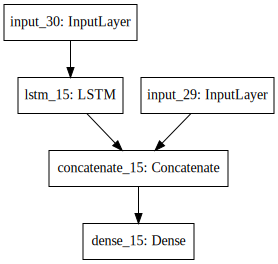

Train on 19678 samples, validate on 7080 samples
Epoch 1/20
19678/19678 [==============================] - 85s 4ms/step - loss: 0.5122 - acc: 0.7424 - val_loss: 0.5403 - val_acc: 0.6863
Epoch 2/20
19678/19678 [==============================] - 77s 4ms/step - loss: 0.4471 - acc: 0.7814 - val_loss: 0.5545 - val_acc: 0.6828
Epoch 3/20
19678/19678 [==============================] - 73s 4ms/step - loss: 0.4466 - acc: 0.7855 - val_loss: 0.5660 - val_acc: 0.6895
Epoch 4/20
19678/19678 [==============================] - 73s 4ms/step - loss: 0.4287 - acc: 0.7977 - val_loss: 0.5488 - val_acc: 0.6977
Epoch 5/20
19678/19678 [==============================] - 73s 4ms/step - loss: 0.3762 - acc: 0.8349 - val_loss: 0.5449 - val_acc: 0.7175
Epoch 6/20
19678/19678 [==============================] - 73s 4ms/step - loss: 0.3536 - acc: 0.8490 - val_loss: 0.6787 - val_acc: 0.7020
Epoch 7/20
19678/19678 [==============================] - 73s 4ms/step - loss: 0.3421 - acc: 0.8586 - val_loss: 0.6386 - val_acc:

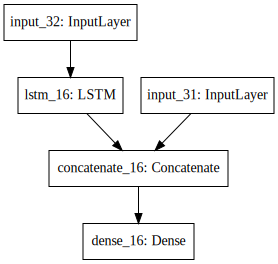

Train on 27461 samples, validate on 7080 samples
Epoch 1/20
27461/27461 [==============================] - 112s 4ms/step - loss: 0.5082 - acc: 0.7435 - val_loss: 0.5338 - val_acc: 0.7602
Epoch 2/20
27461/27461 [==============================] - 100s 4ms/step - loss: 0.4325 - acc: 0.8088 - val_loss: 0.5962 - val_acc: 0.6671
Epoch 3/20
27461/27461 [==============================] - 116s 4ms/step - loss: 0.3851 - acc: 0.8413 - val_loss: 0.5746 - val_acc: 0.7047
Epoch 4/20
27461/27461 [==============================] - 104s 4ms/step - loss: 0.3634 - acc: 0.8543 - val_loss: 0.6772 - val_acc: 0.6593
Epoch 5/20
27461/27461 [==============================] - 101s 4ms/step - loss: 0.3474 - acc: 0.8636 - val_loss: 0.7491 - val_acc: 0.6643
Epoch 6/20
27461/27461 [==============================] - 101s 4ms/step - loss: 0.3337 - acc: 0.8682 - val_loss: 0.6359 - val_acc: 0.6992
Epoch 7/20
27461/27461 [==============================] - 94s 3ms/step - loss: 0.3271 - acc: 0.8710 - val_loss: 0.7098 - va

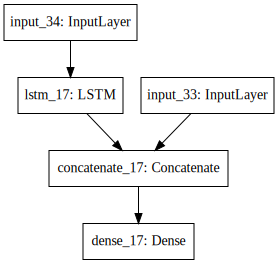

Train on 29835 samples, validate on 7080 samples
Epoch 1/20
29835/29835 [==============================] - 116s 4ms/step - loss: 0.5122 - acc: 0.7276 - val_loss: 0.5635 - val_acc: 0.7044
Epoch 2/20
29835/29835 [==============================] - 122s 4ms/step - loss: 0.4865 - acc: 0.7567 - val_loss: 0.5614 - val_acc: 0.7001
Epoch 3/20
29835/29835 [==============================] - 116s 4ms/step - loss: 0.4628 - acc: 0.7737 - val_loss: 0.5846 - val_acc: 0.6672
Epoch 4/20
29835/29835 [==============================] - 110s 4ms/step - loss: 0.4232 - acc: 0.8143 - val_loss: 0.5631 - val_acc: 0.7225
Epoch 5/20
29835/29835 [==============================] - 109s 4ms/step - loss: 0.4067 - acc: 0.8218 - val_loss: 0.5417 - val_acc: 0.7230
Epoch 6/20
29835/29835 [==============================] - 109s 4ms/step - loss: 0.3837 - acc: 0.8399 - val_loss: 0.5670 - val_acc: 0.7078
Epoch 7/20
29835/29835 [==============================] - 111s 4ms/step - loss: 0.3651 - acc: 0.8523 - val_loss: 0.5869 - v

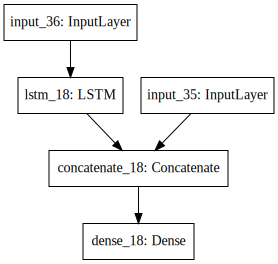

Train on 37210 samples, validate on 7080 samples
Epoch 1/20
37210/37210 [==============================] - 135s 4ms/step - loss: 0.4988 - acc: 0.7407 - val_loss: 0.5420 - val_acc: 0.7386
Epoch 2/20
37210/37210 [==============================] - 135s 4ms/step - loss: 0.4581 - acc: 0.7647 - val_loss: 0.5424 - val_acc: 0.7493
Epoch 3/20
37210/37210 [==============================] - 125s 3ms/step - loss: 0.4306 - acc: 0.7936 - val_loss: 0.5245 - val_acc: 0.7706
Epoch 4/20
37210/37210 [==============================] - 125s 3ms/step - loss: 0.3798 - acc: 0.8316 - val_loss: 0.5157 - val_acc: 0.7709
Epoch 5/20
37210/37210 [==============================] - 124s 3ms/step - loss: 0.3478 - acc: 0.8529 - val_loss: 0.4988 - val_acc: 0.7855
Epoch 6/20
37210/37210 [==============================] - 124s 3ms/step - loss: 0.3242 - acc: 0.8665 - val_loss: 0.5508 - val_acc: 0.7840
Epoch 7/20
37210/37210 [==============================] - 137s 4ms/step - loss: 0.3079 - acc: 0.8748 - val_loss: 0.6621 - v

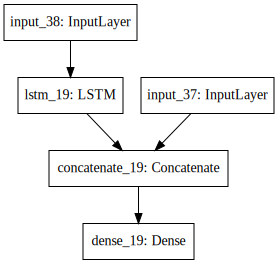

Train on 42507 samples, validate on 7080 samples
Epoch 1/20
42507/42507 [==============================] - 210s 5ms/step - loss: 0.4990 - acc: 0.7414 - val_loss: 0.5422 - val_acc: 0.7061
Epoch 2/20
42507/42507 [==============================] - 166s 4ms/step - loss: 0.4600 - acc: 0.7637 - val_loss: 0.5274 - val_acc: 0.7582
Epoch 3/20
42507/42507 [==============================] - 206s 5ms/step - loss: 0.4268 - acc: 0.7974 - val_loss: 0.5213 - val_acc: 0.7484
Epoch 4/20
42507/42507 [==============================] - 215s 5ms/step - loss: 0.3950 - acc: 0.8239 - val_loss: 0.5001 - val_acc: 0.7696
Epoch 5/20
42507/42507 [==============================] - 216s 5ms/step - loss: 0.3727 - acc: 0.8416 - val_loss: 0.5179 - val_acc: 0.7545
Epoch 6/20
42507/42507 [==============================] - 230s 5ms/step - loss: 0.3523 - acc: 0.8520 - val_loss: 0.5444 - val_acc: 0.7418
Epoch 7/20
42507/42507 [==============================] - 181s 4ms/step - loss: 0.3357 - acc: 0.8619 - val_loss: 0.5031 - v

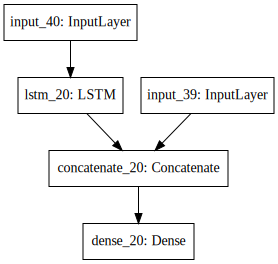

Train on 47512 samples, validate on 2488 samples
Epoch 1/20
47512/47512 [==============================] - 210s 4ms/step - loss: 0.4976 - acc: 0.7456 - val_loss: 0.4073 - val_acc: 0.8211
Epoch 2/20
47512/47512 [==============================] - 194s 4ms/step - loss: 0.4616 - acc: 0.7718 - val_loss: 0.4267 - val_acc: 0.8027
Epoch 3/20
47512/47512 [==============================] - 195s 4ms/step - loss: 0.4408 - acc: 0.7900 - val_loss: 0.4006 - val_acc: 0.8115
Epoch 4/20
47512/47512 [==============================] - 194s 4ms/step - loss: 0.4099 - acc: 0.8129 - val_loss: 0.3642 - val_acc: 0.8219
Epoch 5/20
47512/47512 [==============================] - 184s 4ms/step - loss: 0.3782 - acc: 0.8362 - val_loss: 0.3993 - val_acc: 0.8119
Epoch 6/20
47512/47512 [==============================] - 196s 4ms/step - loss: 0.3541 - acc: 0.8490 - val_loss: 0.4845 - val_acc: 0.7962
Epoch 7/20
47512/47512 [==============================] - 214s 4ms/step - loss: 0.3356 - acc: 0.8593 - val_loss: 0.4795 - v

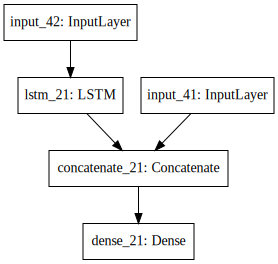

Train on 48850 samples, validate on 1150 samples
Epoch 1/20
48850/48850 [==============================] - 289s 6ms/step - loss: 0.4938 - acc: 0.7453 - val_loss: 0.2569 - val_acc: 0.8661
Epoch 2/20
48850/48850 [==============================] - 281s 6ms/step - loss: 0.4643 - acc: 0.7692 - val_loss: 0.2484 - val_acc: 0.9009
Epoch 3/20
48850/48850 [==============================] - 284s 6ms/step - loss: 0.4291 - acc: 0.8004 - val_loss: 0.2582 - val_acc: 0.8600
Epoch 4/20
48850/48850 [==============================] - 258s 5ms/step - loss: 0.3881 - acc: 0.8303 - val_loss: 0.2006 - val_acc: 0.9157
Epoch 5/20
48850/48850 [==============================] - 256s 5ms/step - loss: 0.3701 - acc: 0.8419 - val_loss: 0.2451 - val_acc: 0.8591
Epoch 6/20
48850/48850 [==============================] - 282s 6ms/step - loss: 0.3549 - acc: 0.8506 - val_loss: 0.1929 - val_acc: 0.9209
Epoch 7/20
48850/48850 [==============================] - 282s 6ms/step - loss: 0.3396 - acc: 0.8594 - val_loss: 0.2049 - v

In [63]:
#print(np.transpose(np.array([np.mean(train_features_18, axis = 1)])).shape)
#fit_model(train_features_reshaped,np.transpose(np.array([np.mean(train_features_18, axis = 1)])),train_labels,test_features_reshaped,np.transpose(np.array([np.mean(test_features_18, axis = 1)])),test_labels,256,30,'multi_input.h5')
#print(train_features_18.shape)
#print(train_features)
max_ids = [200,300,350,400,450,550,650]
for max_id in max_ids:
    train_features_reshaped, test_features_reshaped,train_labels,test_labels,train_features_18, test_features_18 = get_train_test(data,max_id)
    print(train_features_reshaped.shape)
    print(test_features_reshaped.shape)
    fit_model(train_features_reshaped,train_features_18,train_labels,test_features_reshaped,test_features_18,test_labels,32,20,'multi_input.h5')

(19678, 60, 10)
(7080, 60, 10)
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 60, 10)       0                                            
__________________________________________________________________________________________________
input_1 (InputLayer)            (None, 18)           0                                            
__________________________________________________________________________________________________
lstm_1 (LSTM)                   (None, 60)           17040       input_2[0][0]                    
__________________________________________________________________________________________________
concatenate_1 (Concatenate)     (None, 78)           0           input_1[0][0]                    
                                                                 lstm_1[0][0] 

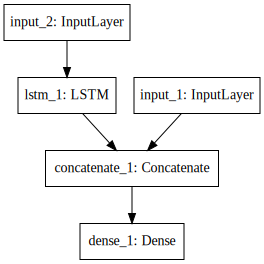

In [17]:
max_ids = [200]
for max_id in max_ids:
    train_features_reshaped, test_features_reshaped,train_labels,test_labels,train_features_18, test_features_18 = get_train_test(data,max_id)
    print(train_features_reshaped.shape)
    print(test_features_reshaped.shape)
    fit_model(train_features_reshaped,train_features_18,train_labels,test_features_reshaped,test_features_18,test_labels,32,20,'multi_input.h5')